In [461]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime, gc, random
import json, numpy as np, pandas as pd, zipfile
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth
# file
import zipfile

# Data preprocessing
import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [462]:

type = 'ScalaSparkNWeight'
hibench_report_simple = pd.read_csv('/home/love1245672/桌面/hibench_report/dataset_simple_d1/'+ type +'.csv')
hibench_report_grid = pd.read_csv('/home/love1245672/桌面/hibench_report/dataset_grid_d1/'+ type +'.csv')
#數據前處理
def processing_df(df):
    df["Type"] = df["Type"].map({"ScalaSparkKmeans":1, "ScalaSparkNWeight":2,"ScalaSparkPagerank":3,"ScalaSparkTerasort":4,"ScalaSparkWordcount":5})
    df["spark.serializer"] = df["spark.serializer"].map({"org.apache.spark.serializer.JavaSerializer": 1, "org.apache.spark.serializer.KryoSerializer": 2})
    df["spark.io.compression.codec"] = df["spark.io.compression.codec"].map({"snappy":1, "lz4":2,"lzf":3})
    #欄位為 str的轉 int , Ex: "26k" -> 26
    df['spark.broadcast.blockSize'] = df['spark.broadcast.blockSize'].str.replace('m','').astype(int)
    df['spark.driver.memory'] = df['spark.driver.memory'].str.replace('g','').astype(int)
    df['spark.executor.memory'] = df['spark.executor.memory'].str.replace('g','').astype(int)
    df['spark.io.compression.lz4.blockSize'] = df['spark.io.compression.lz4.blockSize'].str.replace('k','').astype(int)
    df['spark.io.compression.snappy.blockSize'] = df['spark.io.compression.snappy.blockSize'].str.replace('k','').astype(int)
    df['spark.kryoserializer.buffer'] = df['spark.kryoserializer.buffer'].str.replace('k','').astype(int)
    df['spark.kryoserializer.buffer.max'] = df['spark.kryoserializer.buffer.max'].str.replace('m','').astype(int)
    df['spark.reducer.maxSizeInFlight'] = df['spark.reducer.maxSizeInFlight'].str.replace('m','').astype(int)
    df['spark.shuffle.file.buffer'] = df['spark.shuffle.file.buffer'].str.replace('k','').astype(int)
    df['spark.storage.memoryMapThreshold'] = df['spark.storage.memoryMapThreshold'].str.replace('m','').astype(int)
    return df

def error_index(true_data,pred_data):
    df_true = pd.DataFrame(true_data)
    df_true = df_true.reset_index()
    df_pred = pd.DataFrame(pred_data,columns = ['Duration(s)_pred'])
    df_all = df_true.merge(df_pred, how='inner', left_index=True, right_index=True)
    df_all["error_ratio"] = (abs((df_all['Duration(s)_pred'] - df_all['Duration(s)'])) / df_all['Duration(s)']*100)
    df_all["mse"] = (df_all['Duration(s)'] - df_all['Duration(s)_pred']) ** 2
    
    return df_all["error_ratio"].mean()

hibench_report_simple = processing_df(hibench_report_simple)
hibench_report_grid = processing_df(hibench_report_grid)

In [463]:
pd.set_option('display.max_columns', None)
hibench_report_simple.nsmallest(10,"Duration(s)")
#hibench_report[(hibench_report["spark.executor.cores"] == 8)].nsmallest(10,"Duration(s)")

,Type,Date,Time,Input_data_size,Duration(s),Throughput(bytes/s),Throughput/node,spark.broadcast.blockSize,spark.default.parallelism,spark.driver.cores,spark.driver.memory,spark.executor.cores,spark.executor.instances,spark.executor.memory,spark.io.compression.codec,spark.io.compression.lz4.blockSize,spark.io.compression.snappy.blockSize,spark.kryoserializer.buffer,spark.kryoserializer.buffer.max,spark.memory.fraction,spark.memory.storageFraction,spark.reducer.maxSizeInFlight,spark.serializer,spark.shuffle.file.buffer,spark.shuffle.memoryFraction,spark.shuffle.sort.bypassMergeThreshold,spark.storage.memoryFraction,spark.storage.memoryMapThreshold,spark.storage.unrollFraction
295,2,2023-04-07,01:27:53,163189361,92.189,1770160,885080,48,9,7,10,4,4,8,2,59,118,54,87,0.55,0.56,63,1,125,0.23,486,0.26,408,0.20
646,2,2023-04-09,03:06:18,163189361,92.526,1763713,881856,72,15,1,6,4,4,8,2,13,33,81,17,0.51,0.18,64,2,118,0.71,401,0.59,5,0.20
355,2,2023-04-07,09:46:02,163189361,92.767,1759131,879565,44,13,3,10,4,4,8,1,105,64,6,61,0.63,0.11,52,1,42,0.66,469,0.19,112,0.60
302,2,2023-04-07,02:26:21,163189361,92.980,1755101,877550,8,5,2,10,4,4,8,2,72,56,52,58,0.57,0.33,75,2,75,0.17,177,0.73,381,0.61
375,2,2023-04-07,12:27:06,163189361,93.012,1754497,877248,27,6,7,9,4,4,8,2,71,113,86,87,0.77,0.66,120,1,4,0.64,716,0.26,111,0.12
186,2,2023-04-06,10:37:06,163189361,93.253,1749963,874981,61,11,7,5,8,2,16,2,33,39,105,29,0.76,0.44,63,2,89,0.48,304,0.58,320,0.71
276,2,2023-04-06,22:54:10,163189361,93.357,1748014,874007,32,11,8,12,4,4,8,2,126,93,50,125,0.73,0.24,114,2,20,0.83,768,0.15,172,0.53
651,2,2023-04-09,03:47:20,163189361,93.505,1745247,872623,57,2,1,12,4,4,8,2,52,67,20,96,0.60,0.18,94,2,113,0.30,101,0.67,439,0.40
260,2,2023-04-06,20:48:14,163189361,93.604,1743401,871700,28,15,3,4,8,2,16,2,114,64,55,99,0.49,0.52,66,2,41,0.36,465,0.44,363,0.69
666,2,2023-04-09,05:55:22,163189361,93.729,1741076,870538,8,14,2,7,8,2,16,2,101,75,117,72,0.49,0.17,47,1,51,0.35,143,0.70,82,0.24


In [464]:
def mix_pred(forest_pred, svr_pred):
    forest_df_pred = pd.DataFrame(forest_pred,columns = ['Duration(s)_fr'])
    forest_df_pred = forest_df_pred.reset_index()
    svr_df_pred = pd.DataFrame(svr_pred,columns = ['Duration(s)_svr'])
    svr_df_pred = svr_df_pred.reset_index()
    df_all = forest_df_pred.merge(svr_df_pred, how='inner', left_index=True, right_index=True)
    df_all["mix_pred"] = (df_all["Duration(s)_fr"] + df_all["Duration(s)_svr"]) / 2

    return df_all["mix_pred"].tolist()

In [465]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore', message='A column-vector y was passed when a 1d array was expected.')


mean_mse_rf = 0
mean_error_rf = 0
mean_mse_xgf = 0
mean_error_xgf = 0
mean_mse_svr = 0
mean_error_svr = 0
mean_mse_knr = 0
mean_error_knr = 0
mean_mse_mix = 0
mean_error_mix = 0
for i in range(20):
    
    selected_data_simple = hibench_report_simple.sample(n=90, random_state=i)
    selected_data_grid = hibench_report_grid.sample(n=360, random_state=i)

    train_data_mix = pd.concat([selected_data_simple.sample(n=90, random_state=i), selected_data_grid.sample(n=360, random_state=i)])

    X_train = train_data_mix[['spark.driver.memory','spark.driver.cores','spark.executor.instances','spark.reducer.maxSizeInFlight','spark.shuffle.file.buffer','spark.shuffle.sort.bypassMergeThreshold','spark.memory.fraction','spark.memory.storageFraction','spark.shuffle.memoryFraction', 'spark.storage.memoryFraction','spark.storage.unrollFraction', 'spark.default.parallelism','spark.broadcast.blockSize', 'spark.storage.memoryMapThreshold','spark.io.compression.codec', 'spark.io.compression.lz4.blockSize','spark.io.compression.snappy.blockSize', 'spark.kryoserializer.buffer.max','spark.kryoserializer.buffer','spark.serializer']]
    y_train = train_data_mix[['Duration(s)']]
    
    # 從剩餘的數據中選擇作為測試集
    test_data_simple = hibench_report_simple[~hibench_report_simple.index.isin(selected_data_simple.index)].sample(n=10, random_state=i)
    test_data_grid = hibench_report_grid[~hibench_report_grid.index.isin(selected_data_grid.index)].sample(n=10, random_state=i)
    test_data = pd.concat([test_data_simple, test_data_grid])

    X_test = test_data[['spark.driver.memory','spark.driver.cores','spark.executor.instances','spark.reducer.maxSizeInFlight','spark.shuffle.file.buffer','spark.shuffle.sort.bypassMergeThreshold','spark.memory.fraction','spark.memory.storageFraction','spark.shuffle.memoryFraction', 'spark.storage.memoryFraction','spark.storage.unrollFraction', 'spark.default.parallelism','spark.broadcast.blockSize', 'spark.storage.memoryMapThreshold','spark.io.compression.codec', 'spark.io.compression.lz4.blockSize','spark.io.compression.snappy.blockSize', 'spark.kryoserializer.buffer.max','spark.kryoserializer.buffer','spark.serializer']]
    y_test = test_data[['Duration(s)']]

    forest = RandomForestRegressor(n_estimators=500)
    forest = forest.fit(X_train, y_train)

    xgf = XGBRegressor(learning_rate=0.05,n_estimators = 500)
    xgf = xgf.fit(X_train, y_train)

    svr = SVR(kernel="linear")
    svr = svr.fit(X_train, y_train)

    k = 7  # 鄰居數量
    knn_reg = KNeighborsRegressor(n_neighbors=k,algorithm="auto")
    knn_reg = knn_reg.fit(X_train, y_train)

    

    mean_mse_rf += mean_squared_error(y_test, forest.predict(X_test))
    mean_error_rf += error_index(y_test, forest.predict(X_test))

    mean_mse_xgf += mean_squared_error(y_test, xgf.predict(X_test))
    mean_error_xgf += error_index(y_test, xgf.predict(X_test))

    mean_mse_svr += mean_squared_error(y_test, svr.predict(X_test))
    mean_error_svr += error_index(y_test, svr.predict(X_test))

    mean_mse_knr += mean_squared_error(y_test, knn_reg.predict(X_test))
    mean_error_knr += error_index(y_test, knn_reg.predict(X_test))

#    y_mix_pred = mix_pred(forest.predict(X_test),xgf.predict(X_test))
#    mean_mse_mix += mean_squared_error(y_test, y_mix_pred)
#    mean_error_mix += error_index(y_test, y_mix_pred)

    
print("Mean_MSE_rf:{}".format(mean_mse_rf/20))
print("Mean_Error_rf:{}".format(mean_error_rf/20))
print("")
print("Mean_MSE_xgf:{}".format(mean_mse_xgf/20))
print("Mean_Error_xgf:{}".format(mean_error_xgf/20))
print("")
print("Mean_MSE_svr:{}".format(mean_mse_svr/20))
print("Mean_Error_svr:{}".format(mean_error_svr/20))
print("")
print("Mean_MSE_knr:{}".format(mean_mse_knr/20))
print("Mean_Error_knr:{}".format(mean_error_knr/20))
print("")
#print("Mean_MSE_mix:{}".format(mean_mse_mix/10))
#print("Mean_Error_mix:{}".format(mean_error_mix/10))


執行時間:  1.0726280212402344
Mean_MSE_rf:98.2049369775896
Mean_Error_rf:3.7262990388209225



In [434]:
#from joblib import dump
#dump(forest, '/home/love1245672/桌面/hibench_report/model_store/rf_d2/rf_model_'+type+'.joblib')

<AxesSubplot:>

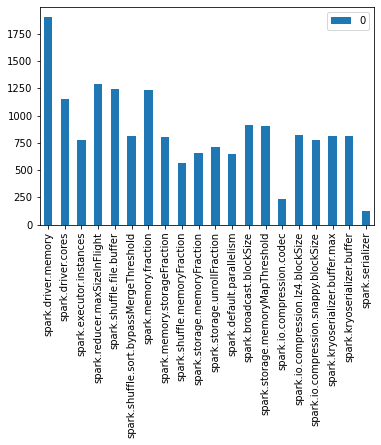

In [435]:
f_importance = xgf.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame.from_dict(data=f_importance, orient='index')
importance_df.plot.bar()

In [436]:
importance = forest.feature_importances_
importance

array([1.27739779e-03, 1.68583630e-02, 1.99656897e-01, 2.92556464e-03,
       1.49254122e-03, 3.83444292e-03, 7.16136584e-01, 7.35681264e-03,
       2.84485982e-03, 9.01687545e-03, 9.53024073e-03, 2.76229647e-03,
       3.91544079e-03, 4.45836042e-03, 5.34787708e-04, 2.37514454e-03,
       4.48562629e-03, 3.60932736e-03, 6.03797522e-03, 8.90461840e-04])